In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize

/mnt/c/Users/a.liard/git/GDL_code/generative-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


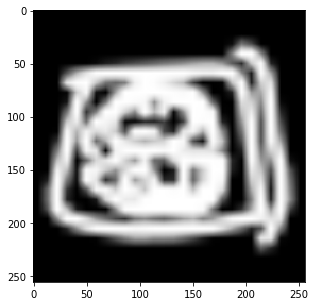

In [7]:
fig = plt.figure(figsize=(5,5))
plt.imshow(imresize(x_train[5].reshape((28,28)), (256,256)), cmap="Greys")

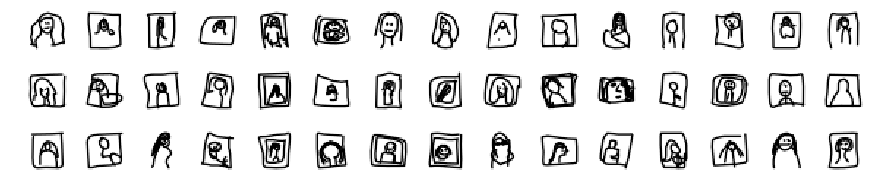

In [9]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(15*3):
    ax = fig.add_subplot(3, 15, i+1)
    ax.axis('off')
    ax.imshow(1-np.fliplr(x_train[i].reshape((28,28))), cmap = 'Greys')


In [10]:
def load_dataset(path):
    dataset = np.load(path)[:5000]
    #normalize & inverse
    dataset = 1 - dataset / 255.0
    dataset = dataset.reshape((dataset.shape[0],28,28,1))
    return dataset,dataset

def load_batch(batch_size, dataset, is_test=False):
    n_batches = int(len(dataset) / batch_size)
    print(n_batches)
    total_samples = n_batches * batch_size
    #sample 
    sample = np.random.choice(range(len(dataset)), total_samples, replace=False)
    for batch in range(n_batches-1):
        yield dataset[sample[batch * batch_size:(batch+1) * batch_size]], dataset[sample[batch * batch_size:(batch+1) * batch_size]]

In [5]:
dataset = load_dataset("data/full_numpy_bitmap_The Mona Lisa.npy")
x_train = dataset[0]

In [11]:
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, LeakyReLU, Dense, Reshape, Activation, Conv2DTranspose, Lambda
from keras.optimizers import Adam
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


In [26]:
z_dim = 100
drop_out = 0.25

encoder_input = Input((28,28,1))
x = encoder_input
x = Conv2D(32, kernel_size=3, strides=1, padding="same", name="Conv1")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
#x = Dropout(rate=drop_out)(x)

x = Conv2D(64, kernel_size=3, strides=2, padding="same", name="Conv2")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
#x = Dropout(rate=drop_out)(x)

x = Conv2D(64, kernel_size=3, strides=2, padding="same", name="Conv3")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
#x = Dropout(rate=drop_out)(x)

x = Conv2D(64, kernel_size=3, strides=1, padding="same", name="Conv4")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
#x = Dropout(rate=drop_out)(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)
x = Dense(z_dim, name="dense")(x)

encoder_output = x
encoder = Model(encoder_input, x)

decoder_input = Input(shape=(z_dim,), name="decoder_input")

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

x = Conv2DTranspose(64, kernel_size=3, strides=1, padding="same")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
#x = Dropout(rate=drop_out)(x)

x =  Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
#x = Dropout(rate=drop_out)(x)

x =  Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
#x = Dropout(rate=drop_out)(x)
                           
x =  Conv2DTranspose(1, kernel_size=3, strides=1, padding="same")(x)
x = Activation("sigmoid")(x)

decoder_output = x
decoder = Model(decoder_input, decoder_output)

model_input = encoder_input
model_output = decoder(encoder_output)

model = Model(model_input, model_output)


In [27]:
def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    
optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss=r_loss)

In [28]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 64)        0         
__________

In [29]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              316736    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 64)        36928     
__________

In [30]:
model.fit(dataset[0], dataset[1], batch_size=16, epochs=10, initial_epoch=0,)

Epoch 1/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0453
Epoch 2/10
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0185
Epoch 3/10
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0140
Epoch 4/10
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0120
Epoch 5/10
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0107
Epoch 6/10
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0099
Epoch 7/10
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0093
Epoch 8/10
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0088
Epoch 9/10
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0084
Epoch 10/10
5000/5000 [==============================] - 15s 3ms/step - loss: 0.0081


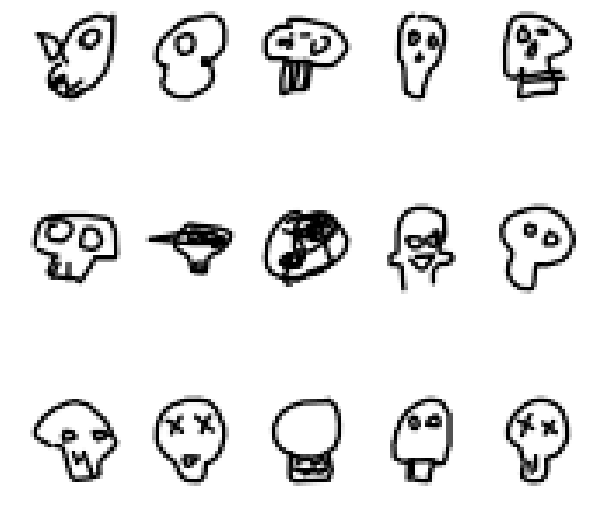

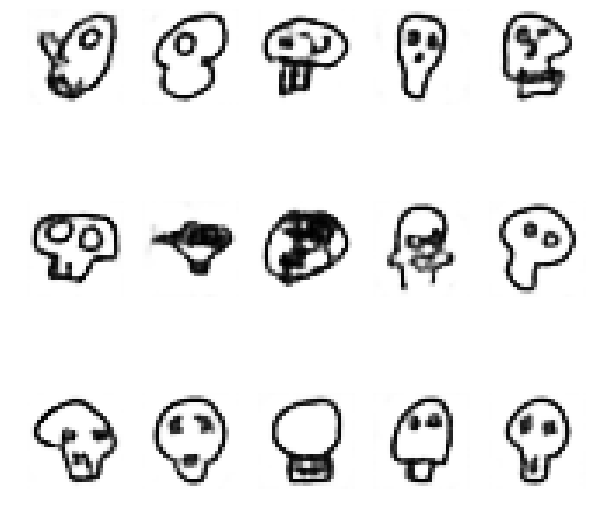

In [31]:
n_to_show = 100
x_train = dataset[0]
rand_index = np.random.choice(len(x_train), n_to_show)
encoded = encoder.predict(x_train[rand_index])

reconst = decoder.predict(encoded)

fig_size = 10
fig = plt.figure(figsize=(fig_size,fig_size))
grid_size = 5
grid_depth = 3
#fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.imshow(1-x_train[rand_index][i,:,:,0], cmap = 'Greys')
plt.show()

fig_size = 10
fig = plt.figure(figsize=(fig_size,fig_size))
grid_size = 5
grid_depth = 3
#fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.imshow(1-reconst[i, :,:,0], cmap = 'Greys')

In [20]:
mins = []
maxs = []
for i in range(z_dim):
    mins.append(np.min(encoded[:,i]))
    maxs.append(np.max(encoded[:,i]))

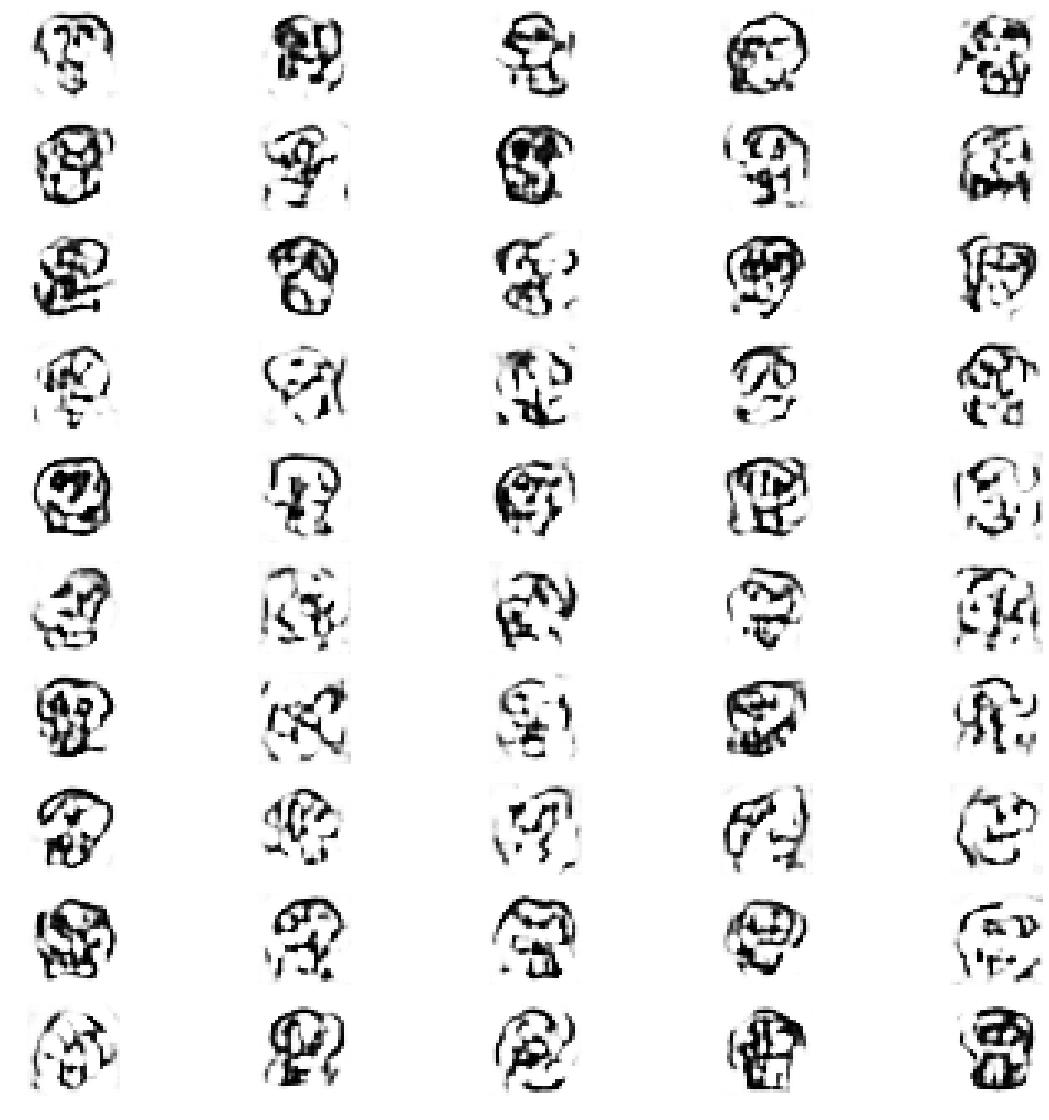

In [33]:
n_to_generate = 50
for i in range(n_to_generate):
    gen = np.array([[np.random.uniform(mins[d], maxs[d]) for d in range(z_dim)]])
    if i>0:
        generated = np.append(generated, gen, axis=0)
    else:
        generated = np.array(gen)
generated.shape

decoded = decoder.predict(generated)
fig_size = 20
fig = plt.figure(figsize=(fig_size,fig_size))
grid_size = 5
grid_depth = 10
#fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.imshow(1-decoded[i, :,:,0], cmap = 'Greys')

# VAE

In [12]:
z_dim = 200
drop_out = 0.25

encoder_input = Input((28,28,1))
x = encoder_input
x = Conv2D(32, kernel_size=3, strides=1, padding="same", name="Conv1")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=drop_out)(x)

x = Conv2D(64, kernel_size=3, strides=2, padding="same", name="Conv2")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=drop_out)(x)

x = Conv2D(64, kernel_size=3, strides=2, padding="same", name="Conv3")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=drop_out)(x)

x = Conv2D(64, kernel_size=3, strides=1, padding="same", name="Conv4")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=drop_out)(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

x = Dense(32, name="dense")(x)
x = LeakyReLU()(x)

z_mean = Dense(z_dim)(x)
z_log_var = Dense(z_dim)(x)

def sampling(args):
    mean, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    return mean + K.exp(log_var/2) * epsilon

encoder_output = Lambda(sampling)([z_mean, z_log_var])

encoder = Model(encoder_input, encoder_output)

decoder_input = Input(shape=(z_dim,), name="decoder_input")

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

x = Conv2DTranspose(64, kernel_size=3, strides=1, padding="same")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=drop_out)(x)

x =  Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=drop_out)(x)

x =  Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)
x= BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=drop_out)(x)
                           
x =  Conv2DTranspose(1, kernel_size=3, strides=1, padding="same")(x)
x = Activation("sigmoid")(x)

decoder_output = x
decoder = Model(decoder_input, decoder_output)

model_input = encoder_input
model_output = decoder(encoder_output)

model = Model(model_input, model_output)


W1230 00:29:42.387622 140623207204672 deprecation_wrapper.py:119] From /mnt/c/Users/a.liard/git/GDL_code/generative-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1230 00:29:42.431631 140623207204672 deprecation_wrapper.py:119] From /mnt/c/Users/a.liard/git/GDL_code/generative-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1230 00:29:42.438036 140623207204672 deprecation_wrapper.py:119] From /mnt/c/Users/a.liard/git/GDL_code/generative-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1230 00:29:42.499396 140623207204672 deprecation_wrapper.py:119] From /mnt/c/Users/a.liard/git/GDL_code/generative-env/lib/python3.6/site-packages/keras/backend/tensorfl

In [13]:
r_loss_factor = 5000

def vae_r_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis=[1,2,3])
    return r_loss_factor * r_loss

def vae_kl_loss(y_true, y_pred):
    kl_loss = -0.5 * K.sum(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return r_loss + kl_loss

optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss = vae_loss, metrics = [vae_r_loss, vae_kl_loss])

W1230 00:29:45.715778 140623207204672 deprecation_wrapper.py:119] From /mnt/c/Users/a.liard/git/GDL_code/generative-env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [17]:
model.fit(dataset[0], dataset[1], batch_size=32, epochs=50, initial_epoch=0,)

Epoch 1/50
5000/5000 [==============================] - 10s 2ms/step - loss: 257.2467 - vae_r_loss: 207.3720 - vae_kl_loss: 49.8747
Epoch 2/50
5000/5000 [==============================] - 14s 3ms/step - loss: 255.9933 - vae_r_loss: 206.1551 - vae_kl_loss: 49.8382
Epoch 3/50
5000/5000 [==============================] - 14s 3ms/step - loss: 255.0006 - vae_r_loss: 205.3158 - vae_kl_loss: 49.6848
Epoch 4/50
5000/5000 [==============================] - 14s 3ms/step - loss: 254.8238 - vae_r_loss: 205.1802 - vae_kl_loss: 49.6436
Epoch 5/50
5000/5000 [==============================] - 15s 3ms/step - loss: 255.0711 - vae_r_loss: 205.2755 - vae_kl_loss: 49.7956
Epoch 6/50
5000/5000 [==============================] - 14s 3ms/step - loss: 254.5556 - vae_r_loss: 204.8859 - vae_kl_loss: 49.6697
Epoch 7/50
5000/5000 [==============================] - 14s 3ms/step - loss: 254.4086 - vae_r_loss: 204.6205 - vae_kl_loss: 49.7881
Epoch 8/50
5000/5000 [==============================] - 14s 3ms/step - loss:

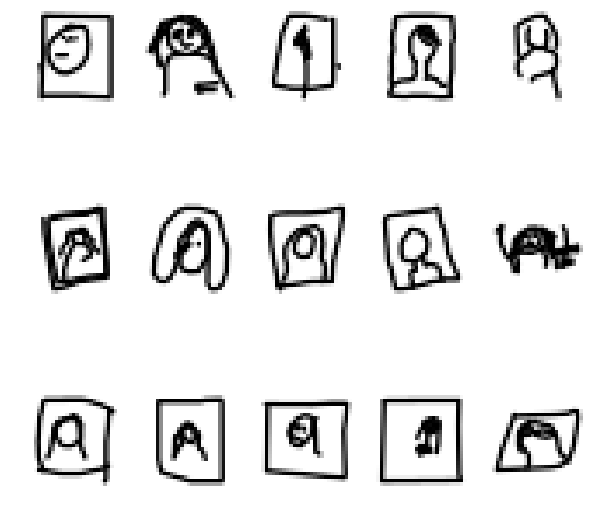

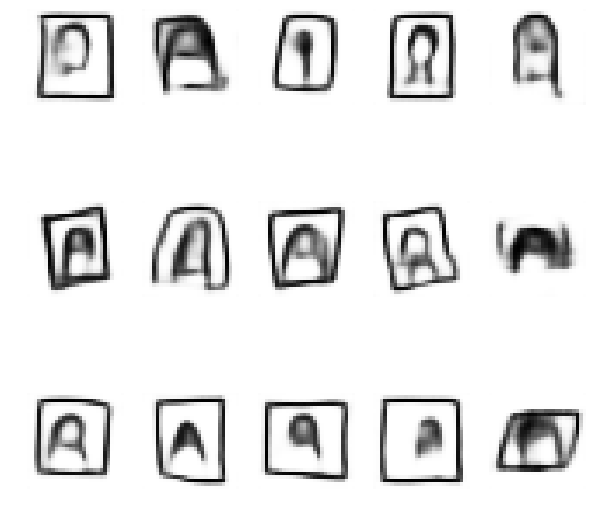

In [18]:
n_to_show = 100
x_train = dataset[0]
rand_index = np.random.choice(len(x_train), n_to_show)
encoded = encoder.predict(x_train[rand_index])

reconst = decoder.predict(encoded)

fig_size = 10
fig = plt.figure(figsize=(fig_size,fig_size))
grid_size = 5
grid_depth = 3
#fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.imshow(1-x_train[rand_index][i,:,:,0], cmap = 'Greys')
plt.show()

fig_size = 10
fig = plt.figure(figsize=(fig_size,fig_size))
grid_size = 5
grid_depth = 3
#fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.imshow(1-reconst[i, :,:,0], cmap = 'Greys')

(100, 28, 28, 1)


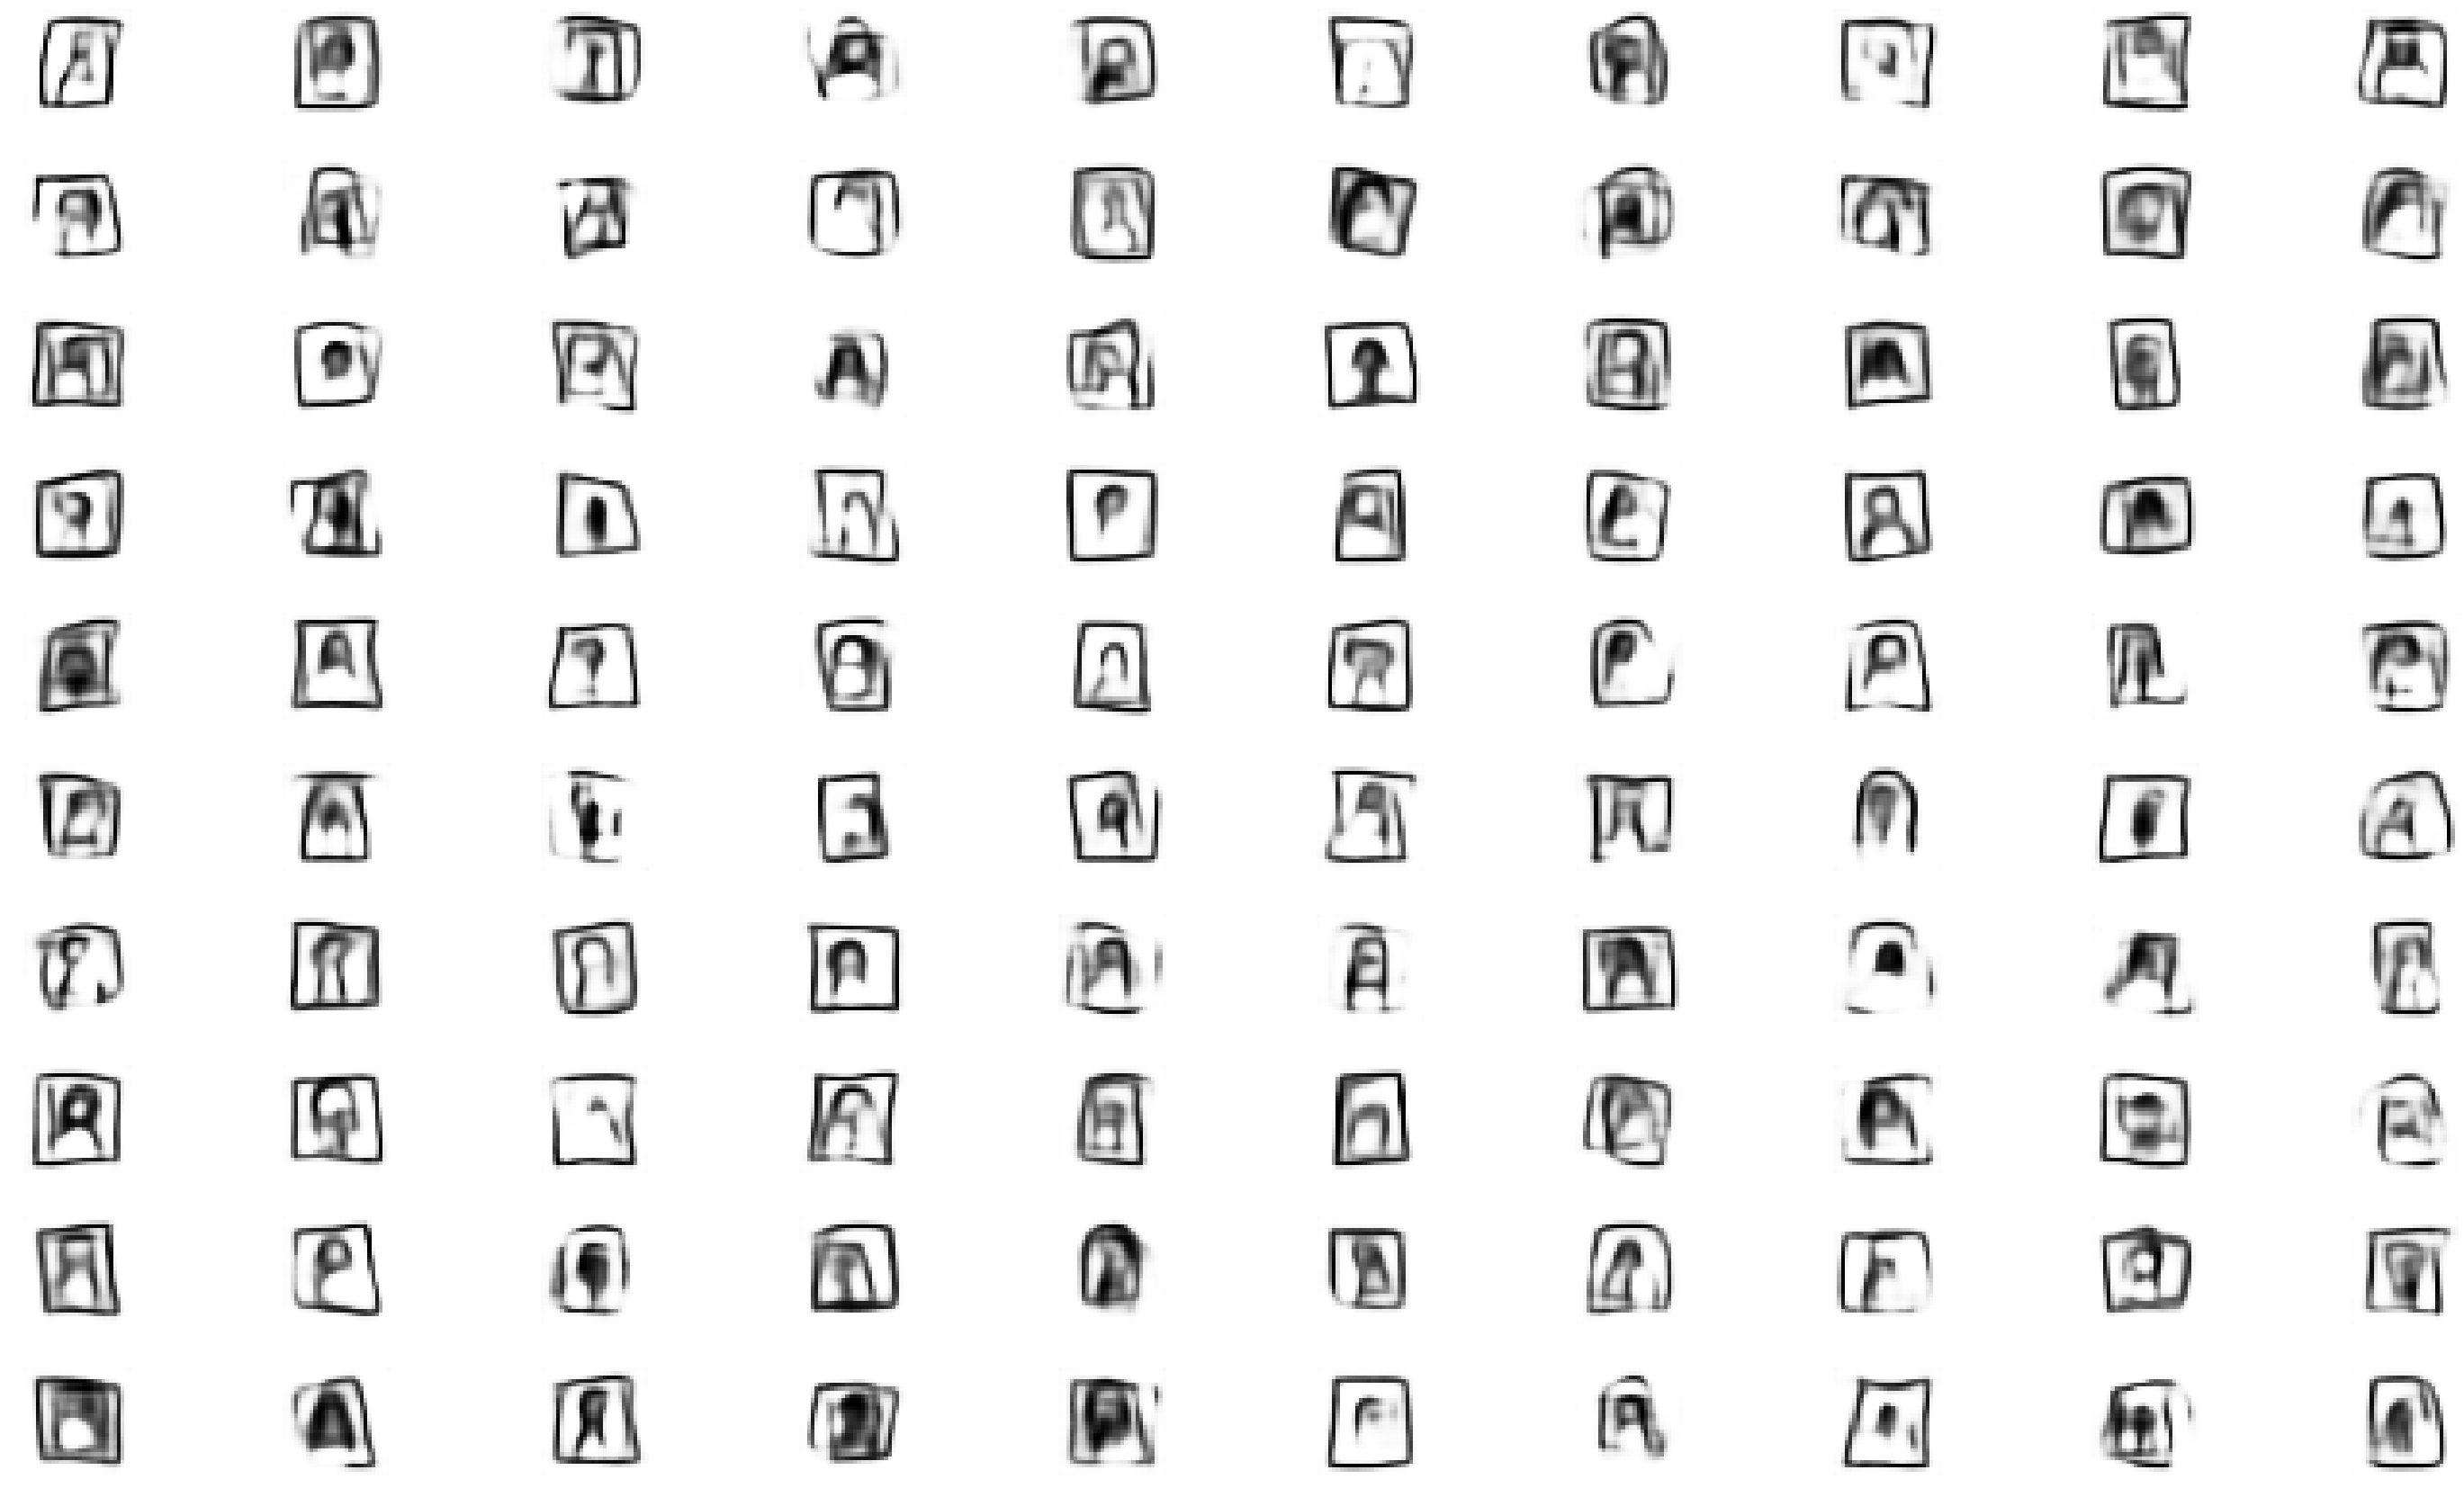

In [19]:
n_to_show = 100

znew = np.random.normal(size = (n_to_show,z_dim))

reconst = decoder.predict(np.array(znew))
print(reconst.shape)
fig = plt.figure(figsize=(50, 30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(1-reconst[i, :,:,0], cmap="Greys")
    ax.axis('off')

plt.show()